## **0. 루브릭**
***

### **1) Transformer와 비교해 변경이 필요한 부분을 서술하였다.**
***

* 제출 노트북 파일 앞부분에 텍스트 블럭으로 서술합니다. 변경이 필요한 블럭을 서술합니다.
* 코드블럭에 변경사항을 주석으로 표시합니다.

> 변경이 필요한 사항을 주석으로 표시하고, 관련 내용을 마크다운 언어로 처리했습니다.

### **2) 모델의 입력 형태에 맞게 전처리를 수행하였다.**
***

* Decoder 기반의 생성모델 임을 감안하여 챗봇 데이터를 변형합니다.

> 양쪽 공백 제거하기, 문장 부호 앞에 공백 추가하기, 여러 개의 공백을 하나로 변환하기, 알파벳, 숫자, 한국어 문자 제외한 모든 문자 공백으로 변환하기, 형태소 단위로 분리하기 등 다양한 문장에 대한 전처리를 하는 함수를 정의하여 챗봇 데이터를 변형했습니다.

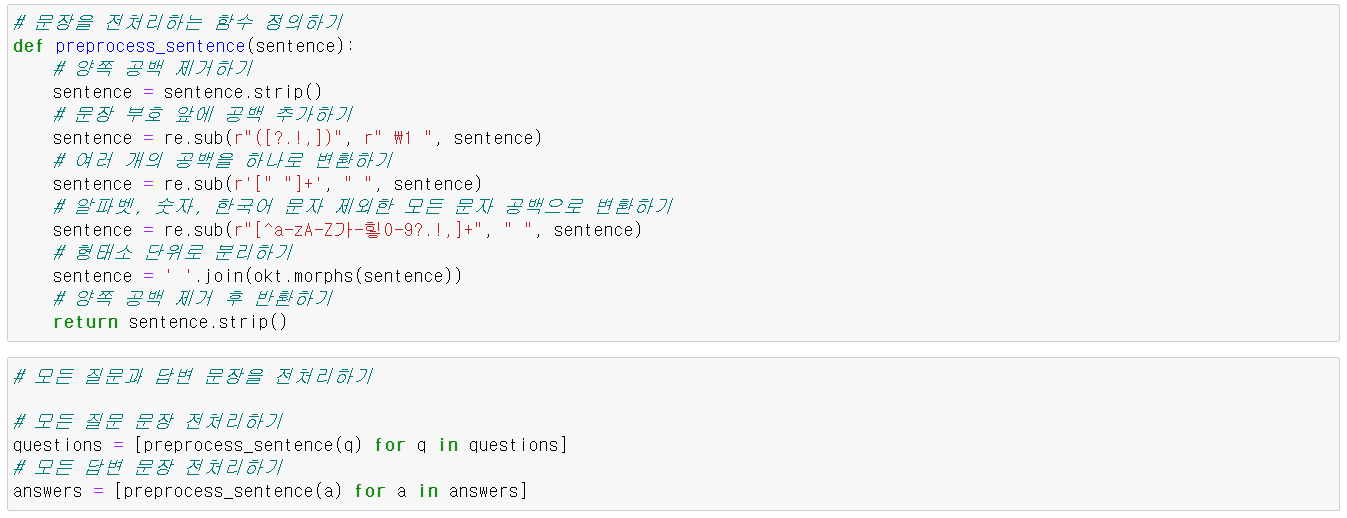

### **3) 모델의 입력 블럭을 GPT 논문에 기반하여 수정하였다.**
***

* 모델의 input이 정상적으로 구성되었는지 확인합니다.

> 질문과 답변에 대한 정수 인코딩, 패딩 처리를 하고, GPT-1 모델 입력 형식에 맞게 질문과 답변을 하나의 시퀀스로 만드는 방식으로 수정했습니다.

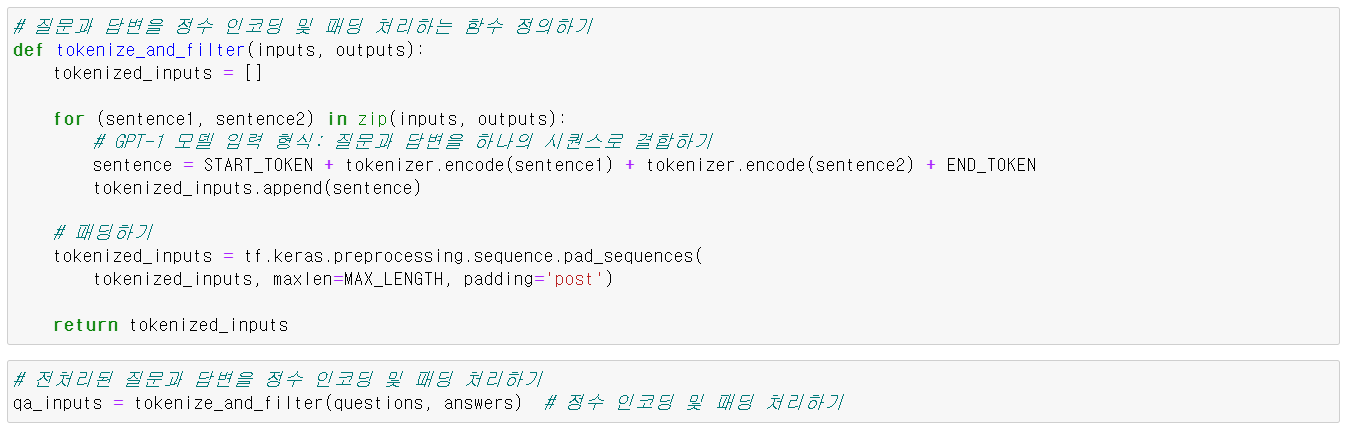

### **4) GPT 모델을 정상적으로 구성하였다.**
### **(model.summary, model.fit 결과 캡쳐 첨부)**
***

* 노드의 transformer 코드를 수정하여 GPT1 모델을 구성합니다.

> 기존 transformer의 특징 중 하나인 인코더 부분을 모두 삭제하고, 디코더 부분의 `인코더-디코더 어텐션` 부분 또한 삭제했습니다.

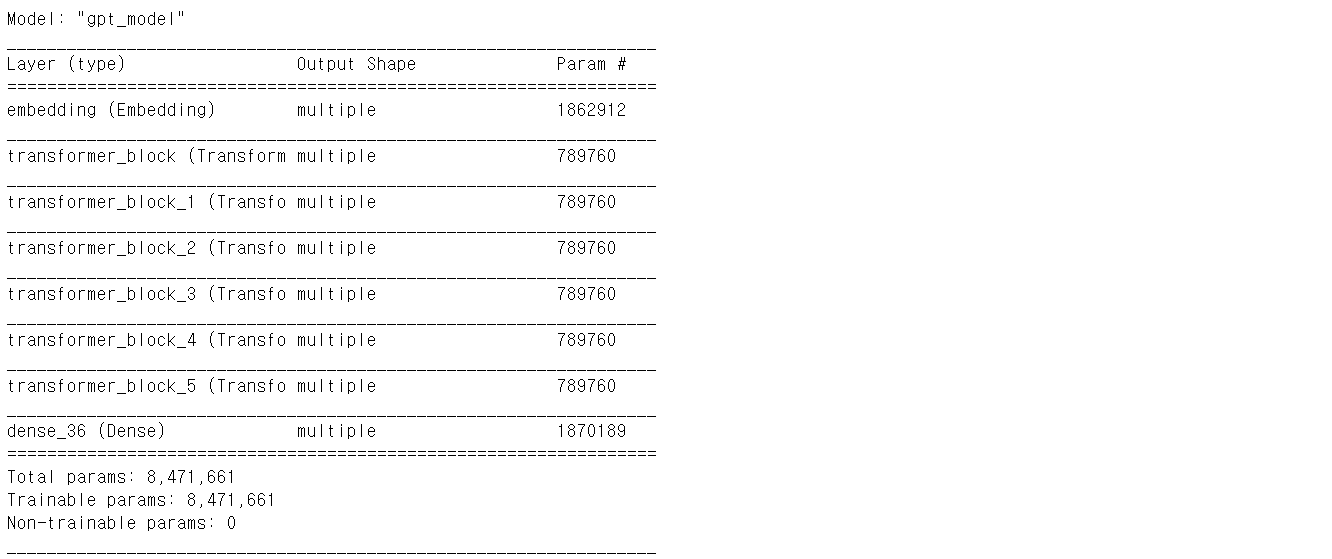

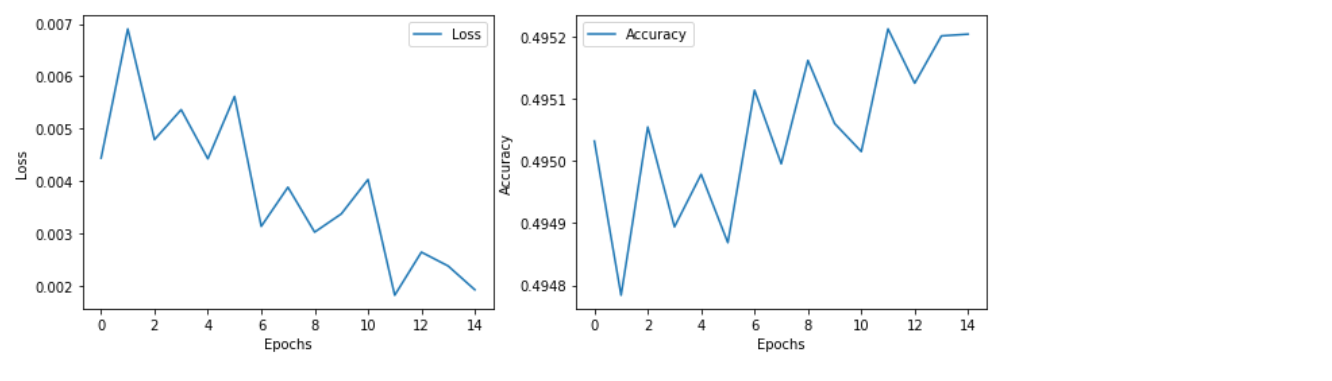

### **5) 입력에 따른 출력이 생성되었다.**
***

* 출력 결과물이 수준에 상관없이 모델이 정상적으로 동작하는지 확인합니다.

> 정상적으로 동작합니다. 데이터 부족인지 혹은 파라미터 수정의 문제인지는 모르겠는데, 답변의 수준은 완벽하지 않습니다.

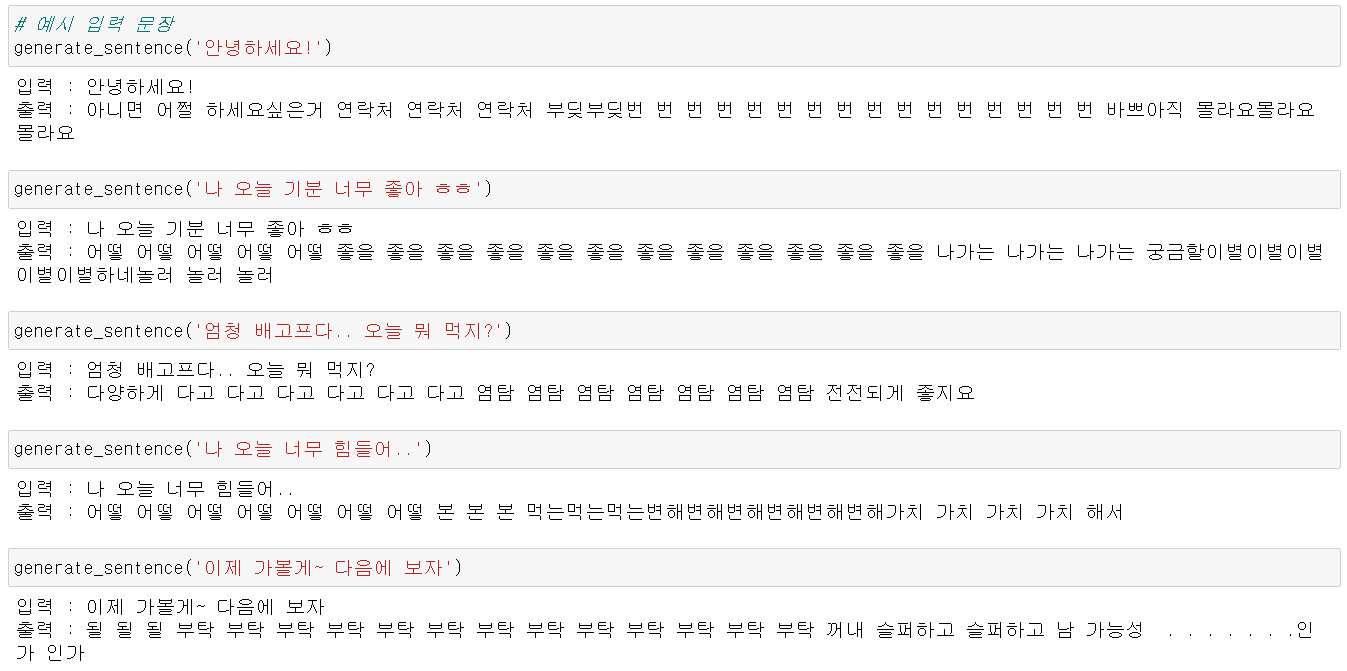

## **1. 프로젝트**

### **STEP 1. 데이터 수집하기**
***

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

In [1]:
# 필요한 라이브러리 불러오기
import tensorflow as tf
import pandas as pd
import re
from konlpy.tag import Okt
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
# 데이터 파일 경로 지정하기
data_file_path = '/aiffel/data/ChatbotData .csv'
# CSV 파일 읽어 DataFrame으로 불러오기
df = pd.read_csv(data_file_path)

### **STEP 2. 데이터 전처리하기**
***

In [3]:
# 질문과 답변 컬럼을 리스트로 변환하기
questions = df['Q'].tolist()  # 질문 컬럼을 리스트로 변환하기
answers = df['A'].tolist()  # 답변 컬럼을 리스트로 변환하기

In [4]:
# Okt 객체를 생성하여 okt 변수에 저장하기
# 이 객체를 사용하여 한국어 문장을 형태소 단위로 분석할 수 있음
okt = Okt()

공백 제거, 문장 부호 처리, 형태소 단위 분리 등을 수행하는 문장 전처리 함수를 구현합니다.

In [5]:
# 문장을 전처리하는 함수 정의하기
def preprocess_sentence(sentence):
    # 양쪽 공백 제거하기
    sentence = sentence.strip()  
    # 문장 부호 앞에 공백 추가하기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 여러 개의 공백을 하나로 변환하기
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 알파벳, 숫자, 한국어 문자 제외한 모든 문자 공백으로 변환하기
    sentence = re.sub(r"[^a-zA-Z가-힣0-9?.!,]+", " ", sentence)
    # 형태소 단위로 분리하기
    sentence = ' '.join(okt.morphs(sentence))
    # 양쪽 공백 제거 후 반환하기
    return sentence.strip()

In [6]:
# 모든 질문과 답변 문장을 전처리하기

# 모든 질문 문장 전처리하기
questions = [preprocess_sentence(q) for q in questions]
# 모든 답변 문장 전처리하기
answers = [preprocess_sentence(a) for a in answers]

In [ ]:
# 질문, 답변 중 일부 살펴보기
questions[:5], answers[:5]

### **Step 3. SubwordTextEncoder 사용하기**
***

내부 단어 토크나이저인 SubwordTextEncoder를 사용해보자.

In [7]:
# SubwordTextEncoder를 사용하여 토크나이저 만들기
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    # 질문과 답변 데이터로부터 서브워드 텍스트 인코더 만들기
    questions + answers, target_vocab_size=2**13)

In [8]:
# 시작 토큰과 종료 토큰 설정하기
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰 확인하기
print('START_TOKEN의 번호 :', [tokenizer.vocab_size])
print('END_TOKEN의 번호 :', [tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [7275]
END_TOKEN의 번호 : [7276]


In [9]:
# 단어 사전의 크기 설정하기
VOCAB_SIZE = tokenizer.vocab_size + 2
# 최대 시퀀스 길이 설정하기
MAX_LENGTH = 30

# 단어 사전의 크기 확인하기
print('단어 사전의 크기 :', VOCAB_SIZE)

단어 사전의 크기 : 7277


최대 길이를 설정하고, 정수를 인코딩 및 패딩해보자.

`GPT-1` 모델의 입력 형식에 맞추어 질문과 답변을 하나의 시퀀스로 결합함.

In [10]:
# 질문과 답변을 정수 인코딩 및 패딩 처리하는 함수 정의하기
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs = []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # GPT-1 모델 입력 형식: 질문과 답변을 하나의 시퀀스로 결합하기
        sentence = START_TOKEN + tokenizer.encode(sentence1) + tokenizer.encode(sentence2) + END_TOKEN
        tokenized_inputs.append(sentence)
    
    # 패딩하기
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs

In [11]:
# 전처리된 질문과 답변을 정수 인코딩 및 패딩 처리하기
qa_inputs = tokenize_and_filter(questions, answers)  # 정수 인코딩 및 패딩 처리하기

In [12]:
# 정수 인코딩 및 패딩한 결과 확인하기
print(qa_inputs[:5])  # 결과 확인을 위해 일부 출력하기

[[7275 5220  713 3851   73  233    3  110 5211    1 7276    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [7275  808   88 1316  593 1521  332   71 4923    1 7276    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [7275  458 1314 4001  705  263  100  230   12  826  192    1 7276    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [7275  458 1314 4001  462  705  263  100  230   12  826  192    1 7276
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [7275 7099 7099 7095 7051 3055 2163  138    2 1707 2516  495   88   50
     1 7276    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


### **Step 4. 모델 구성하기**
***

**Multi-Head Attention 클래스**

여러 개의 어텐션 헤드를 병렬로 사용하여 서로 다른 부분에서 정보를 추출하고 결합함.

이를 통해 모델은 입력 시퀀스의 다양한 위치 간의 관계를 잘 학습할 수 있음.

In [13]:
# Multi-Head Attention 구현하기
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads  # 어텐션 헤드의 수 설정하기
        self.d_model = d_model  # 모델 차원 설정하기

        # 모델 차원이 헤드 수로 나누어 떨어져야 함
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads  # 각 헤드의 차원 설정하기

        # Query, Key, Value를 위한 밀집 레이어 정의하기
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        # 어텐션 결과를 결합하기 위한 밀집 레이어 정의하기
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        # 헤드 수와 깊이로 분할하기
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))  
        # (batch_size, seq_len, num_heads, depth) -> (batch_size, num_heads, seq_len, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]  # 배치 크기 설정하기

        # Query, Key, Value에 대한 밀집 레이어 적용하기
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        # 헤드 수와 깊이로 분할하기
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # 스케일드 닷 프로덕트 어텐션 계산하기
        # (batch_size, num_heads, seq_len_q, depth)
        scaled_attention, _ = scaled_dot_product_attention(q, k, v, mask)
        
        # 모든 헤드를 결합하기
        # (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        # (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 밀집 레이어 적용하기
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output

**스케일드 닷 프로덕트 어텐션 함수(scaled_dot_product_attention)**

주어진 Query(Q), Key(K), Value(V) 간의 어텐션 가중치를 계산하고 이를 이용해 최종 출력을 생성합니다.

In [14]:
# scaled dot product attention 함수 구현하기
def scaled_dot_product_attention(q, k, v, mask):
    # Query와 Key의 내적 계산하기 (batch_size, num_heads, seq_len_q, seq_len_k)
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)  # Key의 차원 크기 설정하기
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  # 차원의 제곱근으로 스케일링하기

    if mask is not None:
        # 마스크를 적용하여 패딩된 위치의 가중치를 매우 작은 값으로 설정하기
        scaled_attention_logits += (mask * -1e9)
    # 소프트맥스 적용하여 가중치 계산하기 (batch_size, num_heads, seq_len_q, seq_len_k)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    # 가중치를 Value에 곱하여 출력 계산하기 (batch_size, num_heads, seq_len_q, depth)
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

**트랜스포머 블록(Transformer Block)**

멀티 헤드 어텐션과 피드 포워드 신경망을 포함합니다.

입력 시퀀스를 처리하고, 각 단계에서 잔차 연결과 층 정규화를 사용하여 더 나은 학습 성능을 제공합니다.

In [15]:
# 트랜스포머 블록 구현하기
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        # 멀티 헤드 어텐션 레이어 초기화하기
        self.mha = MultiHeadAttention(d_model, num_heads)
        
        # 피드 포워드 신경망 정의하기 (2개의 Dense 레이어)
        self.ffn = tf.keras.Sequential([
            # 첫 번째 Dense 레이어: dff 차원으로 변환하고 ReLU 활성화 함수 사용하기
            tf.keras.layers.Dense(dff, activation='relu'),
            # 두 번째 Dense 레이어: 원래 차원으로 변환하기
            tf.keras.layers.Dense(d_model)
        ])
        
        # LayerNormalization 레이어 정의하기 (잔차 연결 후 정규화)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        # 드롭아웃 레이어 정의하기 (훈련 시 과적합 방지)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        # 멀티 헤드 어텐션 수행하기
        attn_output = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)  # 드롭아웃 적용하기
        out1 = self.layernorm1(x + attn_output)  # 잔차 연결 후 LayerNormalization 적용하기

        # 피드 포워드 신경망 통과하기
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)  # 드롭아웃 적용하기
        out2 = self.layernorm2(out1 + ffn_output)  # 잔차 연결 후 LayerNormalization 적용하기

        return out2  # 최종 출력 텐서 반환하기

**GPT Model 클래스**

단어 임베딩, 위치 인코딩, 여러 개의 Transformer 블록, 최종 출력을 위한 밀집 레이어로 구성됩니다.

이 모델은 주어진 시퀀스에 대해 다음 단어를 예측하거나, 시퀀스의 확장을 통해 텍스트 생성을 수행합니다.

In [16]:
# GPT 모델 구성하기
class GPTModel(tf.keras.Model):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, dff, max_positional_encoding):
        super(GPTModel, self).__init__()
        self.token_embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(max_positional_encoding, d_model)
        self.transformer_layers = [TransformerBlock(d_model, num_heads, dff) for _ in range(num_layers)]
        self.final_layer = tf.keras.layers.Dense(vocab_size)
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                                     tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
                                     d_model)
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def get_angles(self, position, i, d_model):
        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angle_rates

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        word_embeddings = self.token_embedding(inputs)
        pos_encoding = self.positional_encoding(seq_len, self.d_model)
        word_embeddings += pos_encoding[:, :seq_len, :]
        x = word_embeddings
        for transformer_layer in self.transformer_layers:
            x = transformer_layer(x, training=True, mask=None)
        final_output = self.final_layer(x)
        return final_output

**하이퍼파라미터 설정 및 모델 생성하기**

트랜스 포머 모델을 생성하기 위해 필요한 하이퍼파라미터를 설정하고 모델을 설정합니다.

In [17]:
# 하이퍼파라미터 설정하기
D_MODEL = 256  # 모델 차원을 늘리기
NUM_LAYERS = 6  # 층 수를 늘리기
NUM_HEADS = 8
DFF = 1024  # 피드포워드 네트워크 차원을 늘리기
MAX_POSITION_ENCODING = MAX_LENGTH
VOCAB_SIZE = tokenizer.vocab_size + 2

In [18]:
# GPT 모델 인스턴스 생성하기
gpt_model = GPTModel(VOCAB_SIZE, 
                     D_MODEL, 
                     NUM_LAYERS, 
                     NUM_HEADS, 
                     DFF, 
                     MAX_POSITION_ENCODING)

In [19]:
# 모델 빌드하기
gpt_model.build(input_shape=(None, MAX_LENGTH))  # 입력 형태를 지정하여 모델 빌드하기

In [20]:
# 커스텀 학습률 스케줄링 정의하기
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [21]:
# 커스텀 학습률 스케줄러를 사용하는 Adam 옵티마이저 정의하기
learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [22]:
# 정확도 계산하는 함수 정의하기
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH))  # y_true 텐서 재구성하기
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [23]:
# 손실 함수 정의하기
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH))  # y_true 텐서 재구성하기
    loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true, y_pred, from_logits=True)  # 손실 계산하기
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)  # 마스크 생성하기
    # 마스크를 적용하여 손실 계산하기
    loss = tf.reduce_sum(loss * mask, axis=-1) / tf.reduce_sum(mask, axis=-1)
    return loss  # 손실 반환하기

In [24]:
# 모델 컴파일하기
gpt_model.compile(optimizer=optimizer, 
              loss=loss_function, 
              metrics=[accuracy])

사용한 모델을 확인해봅니다.

In [47]:
# 모델 요약하기
gpt_model.summary()

Model: "gpt_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1862912   
_________________________________________________________________
transformer_block (Transform multiple                  789760    
_________________________________________________________________
transformer_block_1 (Transfo multiple                  789760    
_________________________________________________________________
transformer_block_2 (Transfo multiple                  789760    
_________________________________________________________________
transformer_block_3 (Transfo multiple                  789760    
_________________________________________________________________
transformer_block_4 (Transfo multiple                  789760    
_________________________________________________________________
transformer_block_5 (Transfo multiple                  78

In [25]:
# 데이터셋 구성하기
BUFFER_SIZE = len(qa_inputs)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((qa_inputs, qa_inputs))
dataset = dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [33]:
# 모델 학습하기
EPOCHS = 15
history = gpt_model.fit(dataset, 
                        epochs=EPOCHS)

Epoch 1/15
185/185 [==============================] - 11s 57ms/step - loss: 0.0044 - accuracy: 0.4950
Epoch 2/15
185/185 [==============================] - 11s 58ms/step - loss: 0.0069 - accuracy: 0.4948
Epoch 3/15
185/185 [==============================] - 11s 58ms/step - loss: 0.0048 - accuracy: 0.4951
Epoch 4/15
185/185 [==============================] - 20s 107ms/step - loss: 0.0054 - accuracy: 0.4949
Epoch 5/15
185/185 [==============================] - 19s 105ms/step - loss: 0.0044 - accuracy: 0.4950
Epoch 6/15
185/185 [==============================] - 19s 104ms/step - loss: 0.0056 - accuracy: 0.4949
Epoch 7/15
185/185 [==============================] - 20s 106ms/step - loss: 0.0031 - accuracy: 0.4951
Epoch 8/15
185/185 [==============================] - 20s 106ms/step - loss: 0.0039 - accuracy: 0.4950
Epoch 9/15
185/185 [==============================] - 20s 106ms/step - loss: 0.0030 - accuracy: 0.4952
Epoch 10/15
185/185 [==============================] - 20s 106ms/step - loss

In [34]:
# 모델 평가하기
loss, accuracy = gpt_model.evaluate(dataset)
print(f'Model Loss: {loss:.4f}')
print(f'Model Accuracy: {accuracy:.4f}')

185/185 [==============================] - 10s 55ms/step - loss: 6.9903e-04 - accuracy: 0.4953
Model Loss: 0.0007
Model Accuracy: 0.4953


학습 과정에서 발생한 손실 정도 그리고 정확도를 시각화해봅니다.

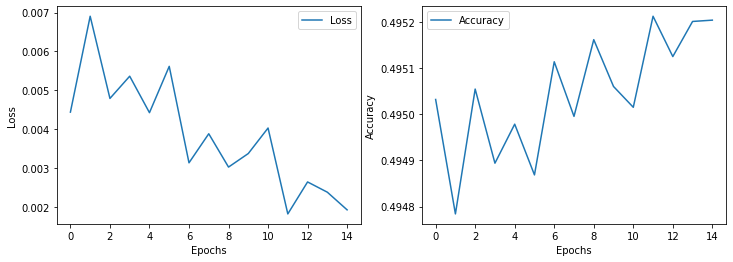

In [46]:
# 학습 손실 및 정확도 시각화하기
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [35]:
# 디코더의 추론을 수행하는 함수 정의하기
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    for i in range(MAX_LENGTH):
        predictions = gpt_model(sentence, training=False)  # 단일 입력 사용하기
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
        
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
        predicted_id = tf.expand_dims(predicted_id[:, -1], axis=-1)  # predicted_id의 차원 확장하기
        sentence = tf.concat([sentence, predicted_id], axis=1)  # 새로운 단어를 입력에 추가하기
    
    return tf.squeeze(output_sequence, axis=0)

In [36]:
# 입력 문장과 출력 문장을 생성하는 함수 정의하기
def sentence_generation(sentence):
    prediction = decoder_inference(sentence)
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])
    return predicted_sentence

In [37]:
# 입력 문장과 출력 문장만 출력하는 함수 정의하기
def generate_sentence(sentence):
    generated_sentence = sentence_generation(sentence)
    print(f'입력 : {sentence}')
    print(f'출력 : {generated_sentence}')

### **STEP 6. 실험 결과 확인하기**
***

**기본 인사**

In [39]:
generate_sentence('안녕하세요!')

입력 : 안녕하세요!
출력 : 아니면 어쩔 하세요싶은거 연락처 연락처 연락처 부딪부딪번 번 번 번 번 번 번 번 번 번 번 번 번 번 번 번 바쁘아직 몰라요몰라요몰라요


**기분이 좋을 때(긍정의 감정)**

In [40]:
generate_sentence('나 오늘 기분 너무 좋아 ㅎㅎ')

입력 : 나 오늘 기분 너무 좋아 ㅎㅎ
출력 : 어떻 어떻 어떻 어떻 어떻 좋을 좋을 좋을 좋을 좋을 좋을 좋을 좋을 좋을 좋을 좋을 좋을 나가는 나가는 나가는 궁금할이별이별이별이별이별하네놀러 놀러 놀러 


**배고플 때**

In [41]:
generate_sentence('엄청 배고프다.. 오늘 뭐 먹지?')

입력 : 엄청 배고프다.. 오늘 뭐 먹지?
출력 : 다양하게 다고 다고 다고 다고 다고 다고 염탐 염탐 염탐 염탐 염탐 염탐 염탐 전전되게 좋지요


**기분이 좋지 않을 때(부정의 감정)**

In [42]:
generate_sentence('나 오늘 너무 힘들어..')

입력 : 나 오늘 너무 힘들어..
출력 : 어떻 어떻 어떻 어떻 어떻 어떻 어떻 본 본 본 먹는먹는먹는변해변해변해변해변해변해가치 가치 가치 가치 해서


**헤어질 때 인사**

In [45]:
generate_sentence('이제 가볼게~ 다음에 보자')

입력 : 이제 가볼게~ 다음에 보자
출력 : 될 될 될 부탁 부탁 부탁 부탁 부탁 부탁 부탁 부탁 부탁 부탁 부탁 부탁 부탁 꺼내 슬퍼하고 슬퍼하고 남 가능성  . . . . . . .인가 인가 


## 2. **회고**

Transformer 모델과 더불어서 논문을 기반으로 GPT-1 모델에 기반한 챗봇도 만들어 봤는데, 결과가 정확하게 나오지 않아서 아쉽지만, 그래도 챗봇 만들기에 성공한 것 같아 기분이 좋았다. 오늘을 기점으로 Exploration 단계가 끝났는데, 앞으로의 해커톤 및 고잉디퍼 단계에서도 한걸음 더 성장할 수 있게 열심히 노력해야 겠다. 